# Import Libraries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output
from collections import OrderedDict
from matplotlib.patches import Rectangle
import os
from skimage import io
from skimage import exposure
import natsort as ns
import multiprocessing
from tqdm import tqdm 
from skimage.util import *
import sklearn

# Load Images

In [2]:
path = os.getcwd()

im_dir = r''+ path + '/Zurich_dataset/images_tif/'
gt_dir = r''+ path + '/Zurich_dataset/groundtruth/'

im_names = ns.natsorted(os.listdir(im_dir))
gt_names = ns.natsorted(os.listdir(gt_dir))
print("images: %i " % len(im_names))
print("ground truth images: %i " % len(gt_names))

def im_load(path, offset=2): # for now, only return highest [max_size] pixels, multiple of patch_size
    """load a TIF image"""
    image = np.asarray(io.imread(path)).astype(float)
    #print(image.shape)
    return np.asarray(image[offset:,offset:,:])


images: 20 
ground truth images: 20 


In [3]:
max_size = 512
imgs = np.asarray([im_load(im_dir + im_name) for im_name in im_names])
gt = np.asarray([im_load(gt_dir + gt_name) for gt_name in gt_names])
print(imgs.shape)

(20,)


In [4]:
# Loaded a set of images
def imgs_stretch_eq(imgs):
    imgs_stretch, imgs_eq = [], []
    for im in imgs:
        # Contrast stretching
        p2, p98 = np.percentile(im, (2, 98))
        img_stretch = im.copy()
        img_eq = im.copy()
        for band in range(im.shape[-1]):
            img_stretch[:,:,band] = exposure.rescale_intensity(im[:,:,band], in_range=(p2, p98))
            img_eq[:,:,band] = exposure.equalize_hist(img_stretch[:,:,band])
        
        # append images
        imgs_stretch.append(img_stretch)
        imgs_eq.append(img_eq)
        
    # convert to np arrays
    imgs_stretch = np.asarray(imgs_stretch)
    imgs_eq = np.asarray(imgs_eq)
    return imgs_stretch, imgs_eq 

imgs_stretch, imgs_eq = imgs_stretch_eq(imgs)

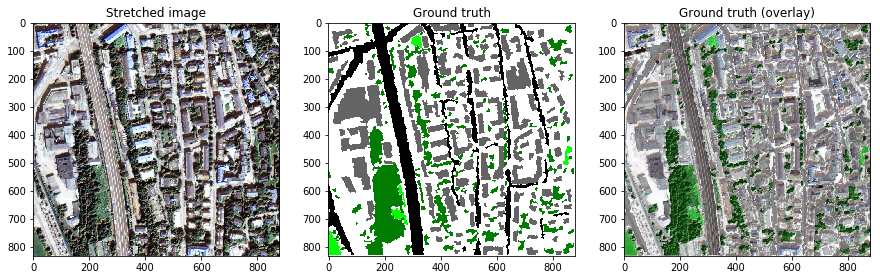

In [5]:
# Show image, its groundtruth image and overlay (to verify matching)
i = 1
alpha=.6
overlay = imgs_eq[i][:,:,:3]*alpha+gt[i]/255*(1-alpha)

# TODO don't stretch image

fig, axes = plt.subplots(1,3)
fig.set_size_inches(15,7)
axes[0].imshow(imgs_eq[i][:,:,:3], cmap='Greys_r')
axes[1].imshow(gt[i]/255, cmap='Greys_r')
axes[2].imshow(overlay, cmap='Greys_r')
axes[0].set_title("Stretched image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
plt.show()

In [6]:
imgs = imgs_eq # continue using stretched image

In [7]:
print(np.shape(imgs))
print(np.shape(gt))

(20,)
(20,)


## GT to labels
Next, we need to convert the ground truth (colors) to labels 

In [8]:
# get label corresponding to each color
legend = OrderedDict((('Background',[255, 255, 255]),
          ('Roads',[0, 0, 0]),
          ('Buildings',[100, 100, 100]),
          ('Trees',[0, 125, 0]),
          ('Grass',[0, 255, 0]),
          ('Bare Soil',[150, 80, 0]),
          ('Water',[0, 0, 150]),
          ('Railways',[255, 255, 0]),
          ('Swimming Pools',[150, 150, 255])))

# get class names by increasing value (as done above)
names, colors = [], []
for name, color in legend.items():
    names.append(name)
    colors.append(color)

In [9]:
def gt_color_to_label(gt, maj = False):
    """
    Transform a set of GT image in value range [0, 255] of shape (n_images, width, height, 3) 
    to a set of GT labels of shape (n_images, width, height)
    """
    
    # sum of distinct color values
    gt_new = gt.copy()
    

    # replace colors by new values
    for i in tqdm(range(len(colors))):
        for j in range(np.shape(gt)[0]):# loop over images
            gt_new[j][:,:,0][np.all(gt[j]==colors[i],axis=-1)] = i #np.argsort(colors)[i]    
        
    gt_new = np.asarray([gt_new[j][:,:,0] for j in range(np.shape(gt)[0])])  # only keep first band = label
    
    if maj:
        # return only majority label for each patch
        gt_maj_label = []
        for i in range(len(gt)):
            counts = np.bincount(gt_new[i].flatten())
            gt_maj_label.append(np.argmax(counts))

        gt_new = np.asarray([gt_maj_label]).T
        
    return gt_new

def gt_label_to_color(gt):
    """
    Transform a set of GT labels of shape (n_images, width, height)
    to a set of GT images in value range [0,1] of shape (n_images, width, height, 3) """
    gt_new = np.zeros(gt.shape+(3,))
    for i in range(len(colors)): # loop colors
        gt_new[gt == i,:] = np.divide(colors[i],255)
    return gt_new

In [10]:
gt_maj_label = gt_color_to_label(gt)
flatten = lambda l: [item for sublist in l for item in sublist]
flat_labels = flatten(flatten(gt_maj_label))
print("Unique Labels in GT: ", np.unique(flat_labels))
print(np.shape(gt_maj_label))
gt = gt_maj_label

100%|██████████| 9/9 [00:05<00:00,  1.54it/s]


Unique Labels in GT:  [0. 1. 2. 3. 4. 5. 6. 7. 8.]
(20,)


In [11]:
gt_colors = gt_label_to_color(np.asarray(gt_maj_label))

/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:35: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


[0. 1. 2. 3. 4. 5. 6. 7. 8.] [10495083  3802130  5374142  2531556  1864437   234618  1267384   342084
    33525]


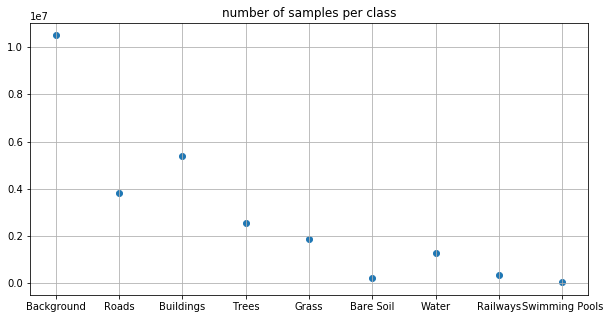

In [12]:
# print some statistics for the class distribution
unique, counts = np.unique(flat_labels,return_counts=True)
print(unique, counts)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,5)
ax.scatter(unique,counts)
ax.set_title('number of samples per class')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names)
ax.grid()
plt.show()

## Get patches

In [13]:
def get_padded_patches(images, patch_size = 64, window_size = 64):
    """
    get padded (mirror) patches for all images
    """
    patches = []
    for im in tqdm(images): # loop over images
        patches_im = np.zeros([int(im.shape[0]/patch_size),int(im.shape[1]/patch_size), window_size, window_size, im.shape[2]])    
        max_x = np.mod(im.shape[0],patch_size)
        max_y = np.mod(im.shape[1],patch_size)
        for i in range(np.shape(im)[2]): # loop over bands, pad original image
            padded = np.lib.pad(im[:-max_x,:-max_y,i], int(np.floor((window_size-patch_size)/2)), 'reflect')
            
            # define image subarea in which to extract patches (divisible by patch_size)
            patches_im[:,:,:,:,i] = view_as_windows(padded, window_size, step=patch_size)
            
        n_patches = int(im.shape[0]/patch_size)*int(im.shape[1]/patch_size) # 25*25 = 625 per image
        patches_im = np.reshape(patches_im, (n_patches, window_size, window_size, im.shape[2]))

        # TODO reshape patches (first dim)
        patches.append(patches_im)
    patches = np.array(patches)
    patches =  np.asarray([patches[i][j] for i in range(len(patches)) for j in range(len(patches[i]))])
    #patches = np.concatenate(patches, axis = 0)
    return patches

def get_gt_patches(images_gt, patch_size = 64):
    """
    get ground truth patches for all images
    """
    gt_patches = []
    for im in tqdm(images_gt):
        max_x = np.mod(im.shape[0],patch_size)
        max_y = np.mod(im.shape[1],patch_size)
        patches_im_gt = view_as_blocks(im[:-max_x,:-max_y], block_shape=(patch_size, patch_size))
        n_patches = int(im.shape[0]/patch_size) * int(im.shape[1]/patch_size) # 25*25 = 625 per image
        patches_im_gt = np.reshape(patches_im_gt, (n_patches, patch_size, patch_size))

        gt_patches.append(patches_im_gt)
    gt_patches = np.array(gt_patches)
    gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
    #patches = np.concatenate(patches, axis = 0)
    return np.asarray(gt_patches)

In [14]:
np.arange(12,16)

array([12, 13, 14, 15])

In [15]:
patch_size = 64

# ids for training, validation and test sets (0-19)
ids_train = np.arange(0,12)
ids_val = np.arange(12,16)
ids_test = np.arange(16,20)

# get training, test and validation sets
x_train = get_padded_patches(imgs[ids_train], patch_size = patch_size, window_size = patch_size)
x_val = get_padded_patches(imgs[ids_val], patch_size = patch_size, window_size = patch_size)
x_test = get_padded_patches(imgs[ids_test], patch_size = patch_size, window_size = patch_size)

y_train = get_gt_patches(gt[ids_train], patch_size = patch_size)
y_val = get_gt_patches(gt[ids_val], patch_size = patch_size)
y_test = get_gt_patches(gt[ids_test], patch_size = patch_size)

print(x_train.shape)
print(y_train.shape)

  0%|          | 0/12 [00:00<?, ?it/s]/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/shape.py:94: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "
100%|██████████| 4/4 [00:00<00:00, 178.00it/s]


(3897, 64, 64, 4)
(3897, 64, 64)


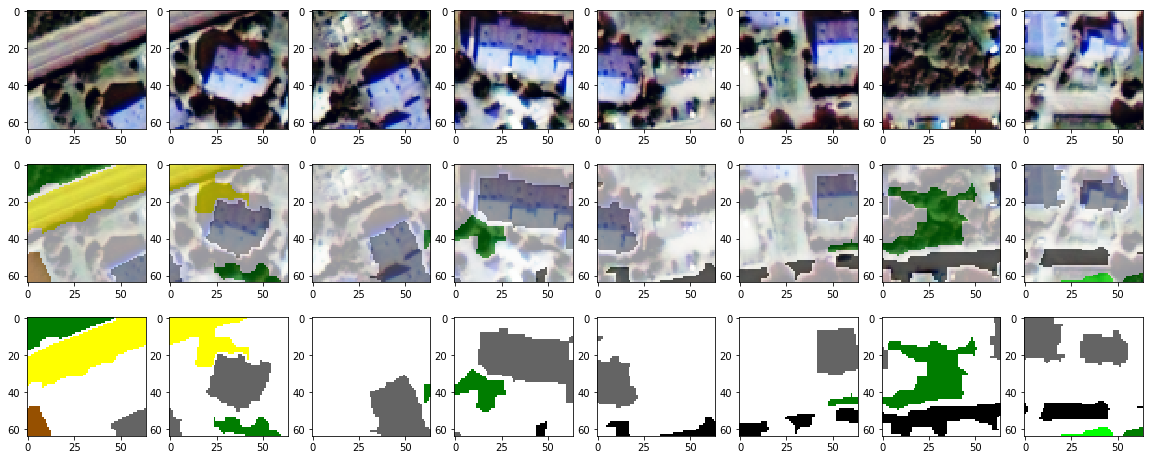

In [16]:
# visualize some patches 
imgs_row = 8
fig, axes = plt.subplots(3,imgs_row)
fig.set_size_inches(20,8)
offset = 10
alpha=.6
for i in range(offset, offset + imgs_row):
    axes[0][i-offset].imshow(x_train[i][:,:,:3])  # images
    axes[1][i-offset].imshow(gt_label_to_color(y_train[i])*alpha+x_train[i][:,:,:3]*(1-alpha))  # ground truth (overlay)
    axes[2][i-offset].imshow(gt_label_to_color(y_train[i]))  # ground truth    

# Keras CNN

Data Split: 
- Training: 12 images (512\*512)
- Validation: 4 images
- Test: 4 images

Tested Architectures: 

| Model | Patch Size | Data Augmentations | Number of Parameters | Testing Precision (avg) | Testing Recall (avg) | Testing f1 score (avg) | Validation / Test accuracy |
| ------- | ------- | ------- | ------- | ------- | ------- |
| U-Net | 64 | Rot 90°, Flipping  | 7,828,200 | 0.87 | 0.858 | 0.86 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.69 | 0.61 | 0.64 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.90 | 0.89 | 0.89 | v |

To Do
- Implement pixelwise class-weighted loss function
- Test same architectures on Pytorch

In [17]:
np.random.seed(42)

from __future__ import print_function

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras import optimizers
from keras.utils import to_categorical
import keras.losses
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.callbacks import *

/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [18]:
# create copies of original data
x_train_im = x_train.copy()
x_val_im = x_val.copy()
x_test_im = x_test.copy()

y_train_im = y_train.copy()
y_val_im = y_val.copy()
y_test_im = y_test.copy()

In [19]:
#x_train_im, x_test, y_train_labels_im, y_test_labels  = train_test_split(im_patches, gt_patches, test_size=.2, random_state = 42)
#x_train_im, x_val_im, y_train_labels_im, y_val_labels_im  = train_test_split(x_train_im, y_train_labels_im, test_size=.25, random_state = 42)

labels_unique = np.unique(y_train.flatten())
print(labels_unique)
class_weights = class_weight.compute_class_weight('balanced', labels_unique, y_train.flatten())    
class_weights[0] = 0 # give less weight to background label class
class_weights[5] = 1 # give less weight to bare soil class
class_weights[8] = 1 # give less weight to swimming pool class
#class_weights = np.concatenate([class_weights, [1]])
#class_weights.append(1) # give less weight to swimming pool class

print("Class weights:")
for i, w in enumerate(class_weights):
    print("%15s: %3.3f"%(names[i],w))

[0. 1. 2. 3. 4. 5. 6. 7. 8.]
Class weights:
     Background: 0.000
          Roads: 0.757
      Buildings: 0.480
          Trees: 1.508
          Grass: 2.105
      Bare Soil: 1.000
          Water: 2.006
       Railways: 6.211
 Swimming Pools: 1.000


In [20]:
n_classes = 9

# convert to numpy arrays
x_train = np.asarray(x_train_im)
x_val = np.asarray(x_val_im)
x_test = np.asarray(x_test_im)

# make y data categorical
y_train = to_categorical(y_train_im, n_classes)
y_val = to_categorical(y_val_im, n_classes)

In [21]:
# remove background class
y_train = y_train[:,:,:,1:]
y_val = y_val[:,:,:,1:]
n_classes = n_classes -1 
class_weights = class_weights[1:]

In [22]:
# print shapes of variables
for var in x_train, y_train, x_val, y_val:
    print(np.shape(var))

(3897, 64, 64, 4)
(3897, 64, 64, 8)
(1117, 64, 64, 4)
(1117, 64, 64, 8)


## UNET

In [23]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.epoch = 0
        self.losses = []
        self.acc = []
        self.val_acc=[]
        self.acc_fn = []
        self.val_acc_fn=[]
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.acc_fn.append(logs.get('fn'))
        self.val_acc_fn.append(logs.get('val_fn'))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.epoch += 1
        fig, axes = plt.subplots(1, 3, sharex=True)
        fig.set_size_inches((20,6))
        
        clear_output()
        
        axes[0].plot(np.arange(self.epoch), self.losses, label="Training")
        axes[0].plot(np.arange(self.epoch), self.val_losses, label="Validation")
        axes[0].legend()
        
        axes[1].plot(np.arange(self.epoch), self.acc, label="Training")
        axes[1].plot(np.arange(self.epoch), self.val_acc, label="Validation")
        axes[1].legend()
        
        axes[2].plot(np.arange(self.epoch), self.acc_fn, label="Training")
        axes[2].plot(np.arange(self.epoch), self.val_acc_fn, label="Validation")
        axes[2].legend()
        
        axes[0].set_title("Loss")
        axes[1].set_title("Accuracy")
        axes[2].set_title("Accuracy (wo. background)")
        plt.show();
        

# callbacks (evaluated every epoch)
# show loss and accuracy figures after each epoch
callback_plot = PlotLosses()

# stop early if after several epochs the accuracy doesn't improive
callback_earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=24, verbose=1, mode='auto')

# decrease learning rate when accuracy stops improving
callback_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1, mode='auto', 
                                epsilon=1e-4, cooldown=0, min_lr=1e-8)

# checkpoint to save weights at every epoch (in case of interruption)
#filepath="weights-improvement.hdf5"
#callback_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

callback_tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

In [24]:
import numpy as np


def augment_images_and_gt(im_patches, gt_patches, normalize=False, rf_h=True, rf_v=True, rot=True, jitter=False):
    """
    :param im_patches: Image to transform
    :param gt_patches: Ground truth to transform
    :param rot: Rotations by +/- 90 degrees
    :param normalize: normalization (default:False)
    :param rf_h: Random horizontal flipping (default: True)
    :param rf_v: Random vertica flipping (default: True)
    :param rot: Randomly rotate image by 0, 90, 180 or 270 degrees (default: True)
    :param jitter: Add random noise in N(0,0.01) to image
    :return: augmented image and ground truth
    """

    im_patches_t = []  # transformed images
    gt_patches_t = []  # transformed labels
    #  normalize image between range (0,1)
    if len(np.shape(im_patches)) < 4:
        flag_singleimg = True
        im_patches = im_patches[np.newaxis]
        gt_patches = gt_patches[np.newaxis]
    else:
        flag_singleimg = False

    for (im, gt) in zip(im_patches, gt_patches):
        if normalize:
            im /= np.max(im)

        # random flipping
        if rf_h:
            if np.random.randint(2):
                im = np.fliplr(im)
                gt = np.fliplr(gt)
        if rf_v:
            if np.random.randint(2):
                im = np.flipud(im)
                gt = np.flipud(gt)

        # rotation
        if rot:
            if np.random.choice([0, 1], p=[.25, .75]):
                k = np.random.randint(1, 4)  # rotate 1, 2 or 3 times by 90 degrees
                im = np.rot90(im, k)
                gt = np.rot90(gt, k)

        # noise injection (jittering), only for image
        if jitter:
            if np.random.randint(2):
                noise = np.random.normal(0, .01, np.shape(im))
                im += noise

        # Scale image between [0, 1]
        im -= np.min(im)
        im /= np.max(im)

        im_patches_t.append(im)
        gt_patches_t.append(gt)

    if flag_singleimg:
        return im_patches_t[0], gt_patches_t[0]
    else:
        return im_patches_t, gt_patches_t


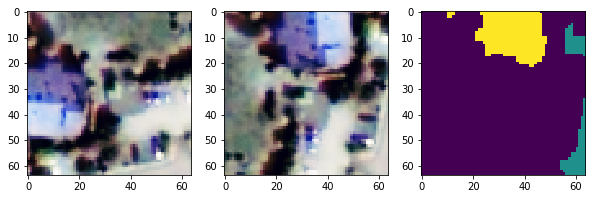

In [25]:
img_idx = 14
im_patches_vis, gt_patches_vis = augment_images_and_gt(x_train_im[img_idx], y_train_im[img_idx], rf_h=True, rf_v=True, rot=True)

fig, axes = plt.subplots(1,3)
fig.set_size_inches((10,5))
axes[0].imshow(x_train_im[img_idx][:,:,:3])
axes[1].imshow(im_patches_vis[:,:,:3])
axes[2].imshow(gt_patches_vis)
plt.show()

In [26]:
# custom data generator
def batch_generator(X, y, batch_size, data_augmentation=False):
    '''
    Return [batch_size] random images from X, y
    '''
    
    while True:
        # choose batch_size random images / labels from the data
        idx = np.random.randint(0, X.shape[0], batch_size)
        im_patches = X[idx]
        gt_patches = y[idx]
        if data_augmentation:
            im_patches_t, gt_patches_t = augment_images_and_gt(im_patches, gt_patches, rf_h=True, rf_v=True, rot=True)

        yield im_patches, gt_patches

In [27]:
def ignore_background_class_accuracy(background_class_id):
    def fn(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_preds = K.argmax(y_pred, axis=-1)
        
        # Replace class_id_preds with class_id_true for recall here
        accuracy_mask = K.cast(K.not_equal(class_id_true, background_class_id), 'int32')
        class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
        class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
        return class_acc
    return fn

In [28]:
# TODO test this function
"""
from keras.backend.tensorflow_backend import _to_tensor

def weighted_pixelwise_crossentropy(class_weights):
    def loss(y_true, y_pred):
        mask = K.ones_like(y_pred)[:, :, :, 0]
        for i in range(len(class_weights)):
            mask_class_weight = K.ones_like(mask) * class_weights[i]
            mask = K.tf.where(y_true[:, :, :, i] > 0, mask_class_weight, mask)
        loss = mask * K.categorical_crossentropy(y_true, y_pred)
        return loss
    return loss
"""

'\nfrom keras.backend.tensorflow_backend import _to_tensor\n\ndef weighted_pixelwise_crossentropy(class_weights):\n    def loss(y_true, y_pred):\n        mask = K.ones_like(y_pred)[:, :, :, 0]\n        for i in range(len(class_weights)):\n            mask_class_weight = K.ones_like(mask) * class_weights[i]\n            mask = K.tf.where(y_true[:, :, :, i] > 0, mask_class_weight, mask)\n        loss = mask * K.categorical_crossentropy(y_true, y_pred)\n        return loss\n    return loss\n'

In [29]:
def get_unet(n_classes,input_shape=x_train.shape[1:]):
    """get UNET model instance"""
    
    inputs = Input(input_shape)

    conv1 = Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
    conv1 = Dropout(.1)(conv1)
    conv1 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Dropout(.1)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Dropout(.1)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Dropout(.1)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Dropout(.1)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Dropout(.1)(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Dropout(.1)(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Dropout(.1)(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (5, 5), activation='relu', padding='same')(up9)
    conv9 = Dropout(.1)(conv9)
    conv9 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation='softmax')(conv9)
    
    model = Model(inputs=[inputs], outputs=[conv10])
    
    sgd = optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc',ignore_background_class_accuracy(0)])

    return model

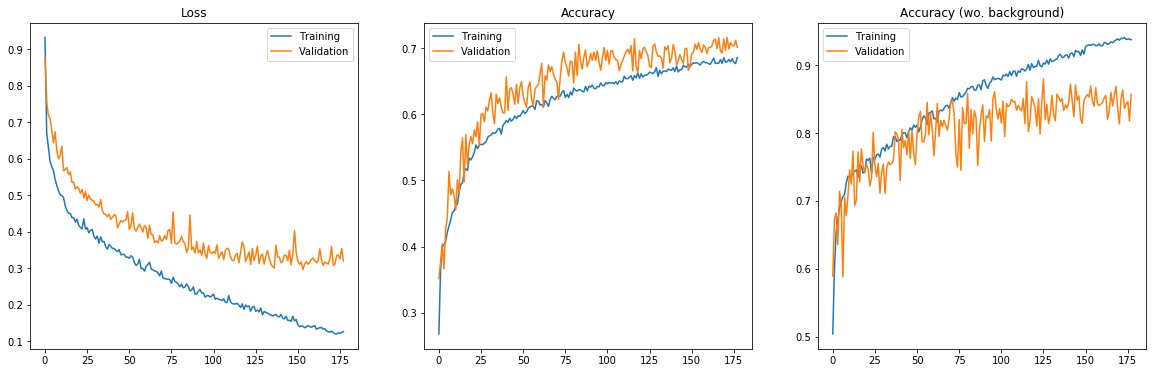

195/195 [==============================] - 33s 168ms/step - loss: 0.1262 - acc: 0.6862 - fn: 0.9375 - val_loss: 0.3197 - val_acc: 0.7016 - val_fn: 0.8570
Epoch 00178: early stopping


In [30]:
batch_size = 20
epochs = 300

def model_train(model, data_augmentation = True):
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(batch_generator(x_train, y_train, 
                                        batch_size=batch_size, data_augmentation=data_augmentation),
                        steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs=epochs,
                        verbose=1,
                        class_weight = class_weights, # weights for loss function
                        validation_data=(x_val, y_val),
                        callbacks=[callback_earlystop,
                                   callback_lr,
                                   #callback_checkpoint,
                                   callback_plot,
                                   callback_tensorboard],
                        workers=multiprocessing.cpu_count()*2,
                        use_multiprocessing=True)

# train the model
model = get_unet(n_classes)
#model.load_weights('model_unet_64_non_augmented.h5')
model_train(model, data_augmentation = True)
#model = load_model('model_unet_64_flip_rot90.h5', custom_objects={'fn': ignore_background_class_accuracy(0)})

In [32]:
# save the model
model.save('model_unet_64_flip_rot90.h5')  # save model, weights

# Prediction

In [143]:
y_pred = model.predict(x_test, batch_size = 5, verbose = 1)
y_pred_label = np.argmax(y_pred,axis=-1)+1

964/964 [==============================] - 4s 4ms/step


In [144]:
# Get accuracy as margin between highest and second highest class
y_pred_rank = np.sort(y_pred,axis=-1) # for every pixel, get the rank
y_pred_max1 = y_pred_rank[:,:,:,-1] # highest proba
y_pred_max2 = y_pred_rank[:,:,:,-2] # second highest proba
y_pred_acc = y_pred_max1 - y_pred_max2

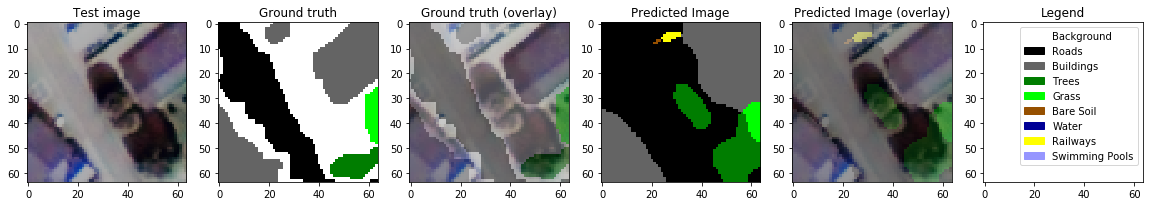

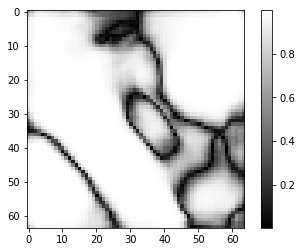

In [145]:
# plot prediction results
im_idx = 1
alpha = .3 # for overlay
fig, axes = plt.subplots(1,6)
fig.set_size_inches(20,20)
fig_im = x_test[im_idx][:,:,:3]*(1-alpha)
fig_test = gt_label_to_color(y_test_im[im_idx])
fig_pred = gt_label_to_color(y_pred_label[im_idx])

# plots
axes[0].imshow(fig_im)
axes[1].imshow(fig_test)
axes[2].imshow(fig_test*alpha+fig_im*(1-alpha))
axes[3].imshow(fig_pred)
axes[4].imshow(fig_pred*alpha+fig_im*(1-alpha))
axes[5].imshow(fig_im*0+1)

# titles
axes[0].set_title("Test image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
axes[3].set_title("Predicted Image")
axes[4].set_title("Predicted Image (overlay)")
axes[5].set_title("Legend")

# legend
legend_data = [[l[0],l[1]] for l in legend.items()]
handles = [Rectangle((0,0),1,1, color = (v/255 for v in c)) for n,c in legend_data]
labels = [n for n,c in legend_data]
axes[5].legend(handles,labels)

# show certitude by network
fig = plt.figure()
plt.imshow(y_pred_acc[im_idx], cmap='gray')
plt.colorbar()

In [146]:
def get_offset(patch_size, img_idx, validation_idx=16):
    """
    return the index index of the first patch in predictions belonging to imgs[img_idx]
    :param validation_idx: index number of first image containing validation images
    """
    offset = 0

    for i in range(validation_idx,validation_idx+img_idx):
        rows = np.shape(imgs[i])[0]
        cols = np.shape(imgs[i])[1]
        # number of tiles from this image
        n_images = int(rows/patch_size) * int(cols/patch_size)

        offset += n_images
    return offset

offset = get_offset(patch_size=64, img_idx=4, validation_idx=16)
offset

964

In [147]:
x_test.shape

(964, 64, 64, 4)

In [294]:
# convert patches to input image
def convert_patches_to_image(im_patches, img_idx, patch_size=64, validation_idx=16, verbose=False):
    """
    Merge patches to image
    :param validation_idx: index number of first image containing validation images
    TO DO implement stride
    """
    image_size = np.shape(imgs[img_idx+validation_idx])
    # initialize empty image
    n_channels = im_patches.shape[-1]
    n_patches_row = int(image_size[0]/patch_size)
    n_patches_col = int(image_size[1]/patch_size)
    
    image_out = np.zeros((n_patches_row*patch_size, n_patches_col*patch_size, n_channels))
    
    offset = get_offset(64, img_idx=img_idx, validation_idx=validation_idx)
    
    for i in range(n_patches_row):
        for j in range(n_patches_col):
            patch = im_patches[offset + (i*n_patches_col+j)]
            image_out[i*patch_size:i*patch_size+patch_size, j*patch_size:j*patch_size+patch_size] = patch
                
    return image_out

images_out = [convert_patches_to_image(gt_label_to_color(y_pred_label), img_idx=i, patch_size = patch_size) for i in range(4)]
images_out_gt = [convert_patches_to_image(gt_label_to_color(y_test_im), img_idx=i, patch_size = patch_size) for i in range(4)]

# TO DO: avoid boundary effect by tiling with a stride less than the patch size.

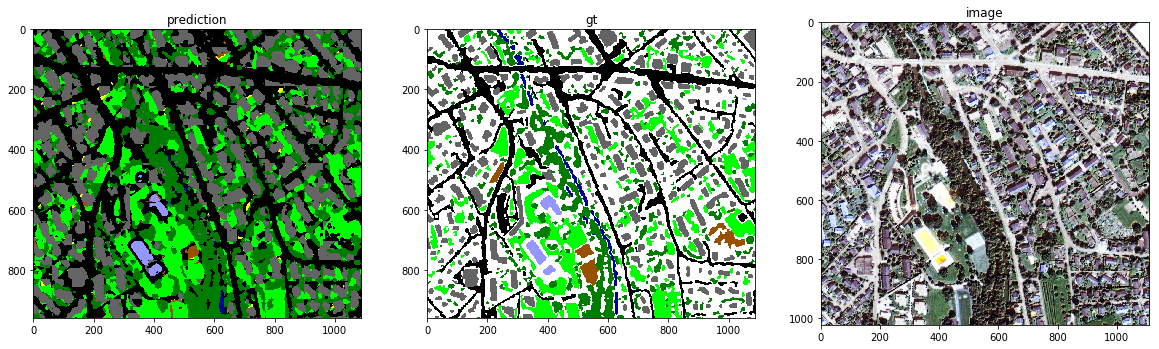

In [298]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches((20,15))
img_idx = 0
axes[0].imshow(images_out[img_idx]) # prediction 
axes[1].imshow(images_out_gt[img_idx]) # gt stitched together 
axes[2].imshow(imgs[img_idx+16][:,:,:3])
[axes[i].set_title(["prediction", "gt", "image"][i]) for i in range(3)]
plt.show()

# Accuracy metrics

In [186]:
# Validation accuracy
# mask background class for evaluation

#TODO ditinguish overall / average accuracy

print("Testing accuracy: %.3f" % sklearn.metrics.accuracy_score(y_pred_label[y_test_im!=0].flatten(),y_test_im[y_test_im!=0].flatten()))
print(sklearn.metrics.classification_report(
    y_pred_label[y_test_im!=0].flatten(),
    y_test_im[y_test_im!=0].flatten(),
    target_names=labels[1:],
    digits=3))

Testing accuracy: 0.830
                precision    recall  f1-score   support

         Roads      0.905     0.784     0.840    601672
     Buildings      0.882     0.835     0.858    497024
         Trees      0.831     0.823     0.827    550551
         Grass      0.772     0.924     0.842    511905
     Bare Soil      0.713     0.679     0.695     69369
         Water      0.498     0.959     0.655      9704
      Railways      0.006     0.009     0.007     11134
Swimming Pools      0.919     0.861     0.889     11092

   avg / total      0.840     0.830     0.832   2262451



# Certainty using Density Forest

In [249]:
# from https://github.com/keras-team/keras/issues/41
from keras import backend as K

def get_activations(model, layer, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
    activations = get_activations([X_batch,0])
    return np.asarray(activations[0])

act_val = get_activations(model, -2, x_val)
act_test = get_activations(model, -2, x_test)

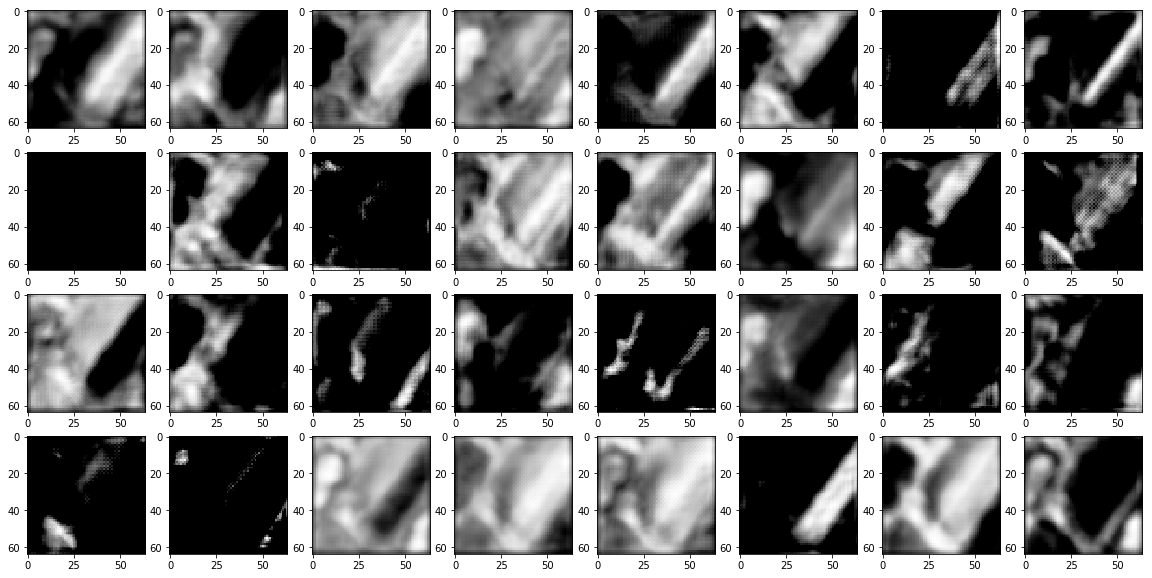

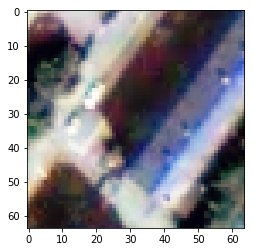

In [250]:
# visualize some activations
fig, axes = plt.subplots(4,8)
fig.set_size_inches(20,10)
for i in range(4):
    for j in range(8):
        axes[i][j].imshow(act_val[im_idx][:,:,i*8+j],cmap='Greys_r')
plt.show()

plt.figure()
plt.imshow(x_val[im_idx][:,:,:3])
plt.show()

# Density Forest Uncertainty Measure
Feed activation weigths into density tree

In [251]:
import sys
sys.path.append('/home/cyrilwendl/SIE-Master/Code') # Path to density Tree package
sys.path.append('/home/cyrilwendl/SIE-Master/Code/density_tree') # Path to density Tree package

from density_tree import density_tree
from density_tree.density_forest import *
from density_tree.density_tree_create import create_density_tree
from sklearn import decomposition
import warnings

In [252]:
act_val = np.reshape(act_val, (act_val.shape[0]*act_val.shape[1]*act_val.shape[2],act_val.shape[3]))
act_test = np.reshape(act_test, (act_test.shape[0]*act_test.shape[1]*act_test.shape[2],act_test.shape[3]))

Variance explained by first 6 components: 0.96


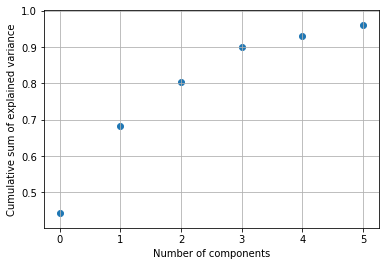

In [254]:
# create density tree for activation weights of training data
dimensions = np.shape(act_val)[-1]

# PCA
pca = decomposition.PCA(n_components=10)
pca.fit(activations_2D)
n_components = len(pca.explained_variance_ratio_[np.cumsum(pca.explained_variance_ratio_)<.95])+1
print("Variance explained by first %i components: %.2f" % (n_components, np.sum(pca.explained_variance_ratio_[:n_components])))
pca = decomposition.PCA(n_components=n_components)
pca.fit(activations_2D)

plt.cla()
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid()
plt.show()

In [257]:
X_val = pca.transform(act_val)
X_test = pca.transform(act_test)
y_val_1D = np.reshape(y_val_im,(y_val_im.shape[0]*y_val_im.shape[1]*y_val_im.shape[2]))

In [258]:
n_points = 1000
dataset_indices = np.arange(len(X_val))

#  draw random samples with replacement
dataset_subset_indices = np.random.choice(dataset_indices, size=n_points, replace=True,)
dataset_subset = X_val[dataset_subset_indices, :]

Variance explained by first 3 components: 0.81


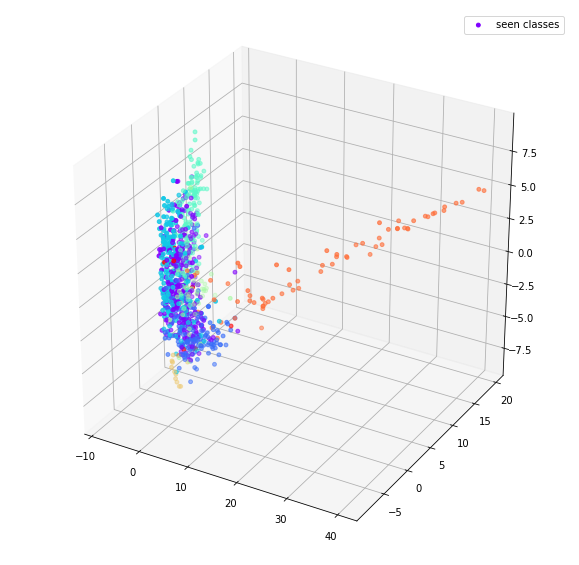

In [260]:
# for interactive Jupyter Notebook
# %matplotlib notebook
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_val[dataset_subset_indices,0], X_val[dataset_subset_indices,1], zs=X_val[dataset_subset_indices,2], c=y_val_1D[dataset_subset_indices], cmap=plt.get_cmap('rainbow'), s=15)
#ax.scatter(X_unseen[:,0], X_unseen[:,1], zs=X_unseen[:,2], c='black', s=30, marker='x', depthshade=False) 
ax.legend(['seen classes','unseen class'])
print("Variance explained by first 3 components: %.2f" % np.sum(pca.explained_variance_ratio_[:3]))

In [261]:
warnings.filterwarnings("ignore")
#root = create_density_tree(X_all, dimensions = n_components, clusters = n_classes, verbose = True)

### Bottlenecks
- `Subset_data`: because of traverse function which looks up data split size?

In [262]:
warnings.filterwarnings("ignore")
subset_data = 0.001
print("Number of points on which to train trees: %i" % int(np.shape(X_val)[0] * subset_data))
root_nodes_seen = density_forest_create(X_val, n_components, n_classes, 10, subset_data, -1)

Number of points on which to train trees: 4575


[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    3.2s remaining:    2.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    5.8s finished


In [306]:
# get probabilities for one image
n_jobs = multiprocessing.cpu_count()
n_images = 256  # len(y_test)
probas_seen = Parallel(n_jobs=n_jobs, verbose=1)(
        delayed(density_forest_traverse)(X_test[im_idx*(patch_size * patch_size):(im_idx+1)*(patch_size * patch_size),:], root_nodes_seen, thresh = .1)
        for im_idx in range(n_images))

100%|██████████| 4096/4096 [00:25<00:00, 158.28it/s]


100%|██████████| 4096/4096 [00:19<00:00, 206.35it/s]
[Parallel(n_jobs=8)]: Done 256 out of 256 | elapsed: 13.6min finished


In [307]:
probas_seen_im = np.reshape(probas_seen.copy(), (n_images, patch_size, patch_size))
 #ad-hoc scaling of probabilities
probas_seen_im = np.log(probas_seen_im)
probas_seen_im = np.add(probas_seen_im, -np.nanmin(probas_seen_im))
probas_seen_im = np.divide(probas_seen_im, np.nanmax(probas_seen_im))

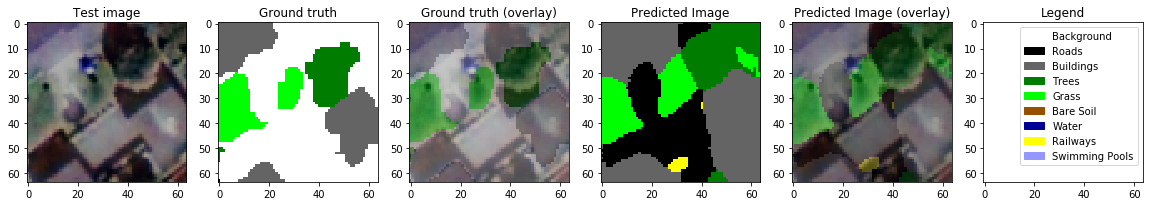

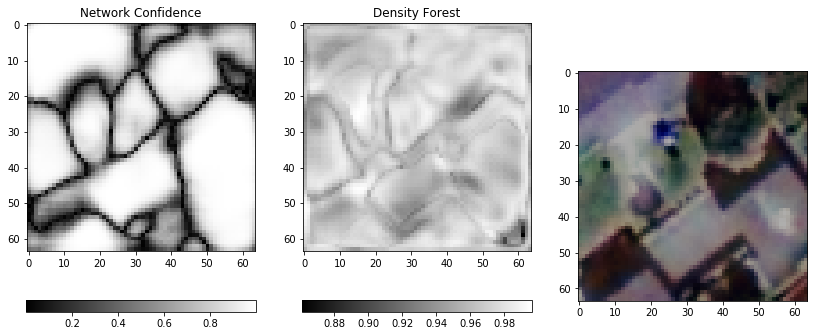

In [308]:
# plot prediction results with new uncertainty
# %matplotlib inline
im_idx = 2
alpha = .3 # for overlay
fig, axes = plt.subplots(1,6)
fig.set_size_inches(20,20)
fig_im = x_test[im_idx][:,:,:3]*(1-alpha)
fig_test = gt_label_to_color(y_test_im[im_idx])
fig_pred = gt_label_to_color(y_pred_label[im_idx])

# plots
axes[0].imshow(fig_im)
axes[1].imshow(fig_test)
axes[2].imshow(fig_test*alpha+fig_im*(1-alpha))
axes[3].imshow(fig_pred)
axes[4].imshow(fig_pred*alpha+fig_im*(1-alpha))
axes[5].imshow(fig_im*0+1)

# titles
axes[0].set_title("Test image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
axes[3].set_title("Predicted Image")
axes[4].set_title("Predicted Image (overlay)")
axes[5].set_title("Legend")

# legend
legend_data = [[l[0],l[1]] for l in legend.items()]
handles = [Rectangle((0,0),1,1, color = (v/255 for v in c)) for n,c in legend_data]
labels = [n for n,c in legend_data]
axes[5].legend(handles,labels)

# show certitude by network
fig, axes = plt.subplots(1,3)
fig.set_size_inches(14,6)
f1 = axes[0].imshow(y_pred_acc[im_idx], cmap='gray')
fig.colorbar(f1, ax=axes[0], orientation='horizontal')
f2 = axes[1].imshow(probas_seen_im[im_idx], cmap='gray')
fig.colorbar(f2, ax=axes[1], orientation='horizontal',spacing='proportional')
axes[0].set_title("Network Confidence")
axes[1].set_title("Density Forest")

# show uncertain places by overlaying red polygons for certain threshold
thresh = .8 # confidence threshold
opacity = .4 # overlay opacity

red_mask = fig_im.copy()*0
red_mask[:,:,0] = 1
fig_im_overlay = fig_im.copy()
mask_vals = probas_seen_im[im_idx]<thresh
fig_im_overlay[mask_vals] = fig_im_overlay[mask_vals]*opacity + red_mask[mask_vals]*(1-opacity)

axes[2].imshow(fig_im_overlay)
plt.show()

In [309]:
av_cert = []
for label in range(n_classes):
    av_cert.append(np.nanmean(probas_seen_im[y_test_im[:n_images]==label])) 
    
av_cert
print("Average certainty within class:")
for i, w in enumerate(av_cert):
    print("%15s: %3.3f"%(names[i+1],w))

Average certainty within class:
          Roads: 0.966
      Buildings: 0.964
          Trees: 0.961
          Grass: 0.968
      Bare Soil: 0.953
          Water: 0.952
       Railways: 0.961
 Swimming Pools: nan


In [323]:
# convert patches to image
im_cert_out = convert_patches_to_image(probas_seen_im[:,:,:,np.newaxis], img_idx=0, patch_size = patch_size, validation_idx=16)

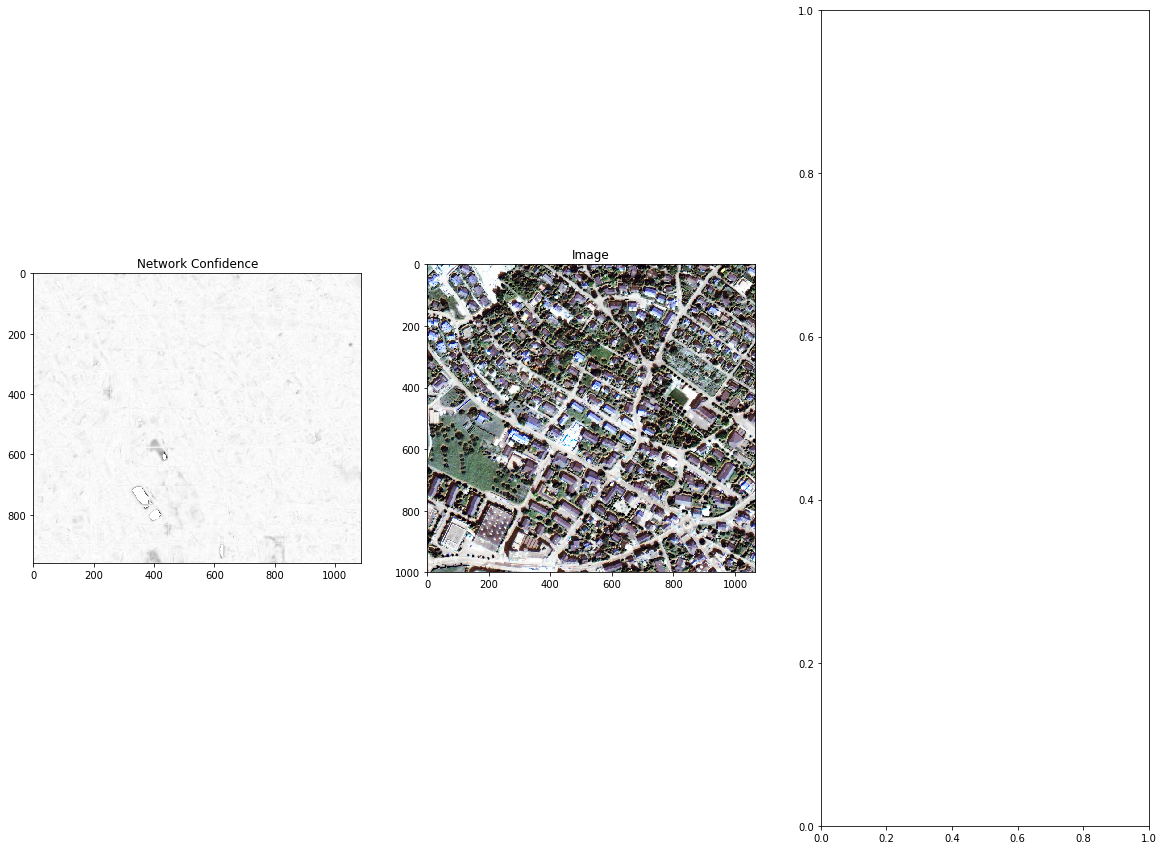

In [329]:
# show certitude by network
fig, axes = plt.subplots(1,3)
fig.set_size_inches(20,15)
axes[0].imshow(im_cert_out[:,:,0], cmap='gray')
axes[1].imshow(imgs[im_idx][:,:,:3], cmap='gray')

axes[0].set_title("Network Confidence")
axes[1].set_title("Image")